# Project Solution

In [1]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans,DBSCAN
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.layers import MaxPooling2D, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
import os

Using TensorFlow backend.


In [2]:
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = 10,10

In [3]:
def load_image(path, gray = True):
    img = cv2.imread(path)  
    if gray :
        return  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def display_image(image):
    plt.imshow(image,'gray')

In [4]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [5]:
def mark_all_faces(image, faces):
    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),1)
    display_image(image)

In [6]:
def crop_face_from_images(images):
    face_images = []
    for img in images:
        faces = face_cascade.detectMultiScale(img)
        if (len(faces) != 0):
            (x,y,w,h) = faces[0]
            face_images.append(cv2.resize(img[y:y+h,x:x+w],(64,64)))
    return face_images

def find_all_faces(image):
    face_images = []
    faces = face_cascade.detectMultiScale(cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY))
    for (x,y,w,h) in faces:
        face_images.append(image[y:y+h,x:x+w])
    
    return face_images , faces

In [7]:
def create_nn():
    ann = Sequential()
    ann.add(Conv2D(128, (3,3), activation='relu', input_shape=[64, 64, 3], padding='same'))
    ann.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    ann.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
    ann.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    ann.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
    ann.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    ann.add(Flatten())
    ann.add(Dense(256, activation='relu'))
    ann.add(Dense(128, activation='relu'))
    ann.add(Dense(45, activation='softmax'))
    return ann

In [8]:
def load_all_image_from_path(path):
    images = []
    
    for img in os.listdir(path):
            img_path = os.path.join(path, img)
            img = load_image(img_path, False)   
            images.append(img)
        
    return images

In [10]:
num_of_neg_people = 44

def prepare_pos_inputs(path):
    images = load_all_image_from_path(path)
    crop_images = crop_face_from_images(images)
    print(len(crop_images))
    print(len(images))
    x_inputs = [];
    for img in crop_images:
        img = cv2.resize(img,(64,64))
        x_inputs.append(img)
    return x_inputs

def prepare_neg_inputs(path):
    images = []
    outputs = []

    for index, img_sub_path in enumerate(os.listdir(path), start = 1):
        for  img in os.listdir(os.path.join(path,img_sub_path)):
            img_path = os.path.join(path, img_sub_path, img)
            img = load_image(img_path, False)  
            face_image = crop_face_from_images([img])
            if face_image:
                images = images + face_image
                out = np.zeros(num_of_neg_people + 1)
                out[index] = 1
                outputs.append(out)
        
    return images, outputs;  

def prepare_outputs(num_of_inputs, positive = True):
    prepare_outputs = []
    for index in range(num_of_inputs):
        output = np.zeros(45)
        output[0] = 1
        prepare_outputs.append(output)
    return prepare_outputs

In [11]:
input_train_pos = prepare_pos_inputs('train_set_pos')
output_train_pos = prepare_outputs(len(input_train_pos))
input_train_neg, output_train_neg = prepare_neg_inputs('train_set_neg')
X_train = np.array(input_train_pos + input_train_neg, np.float32) 
Y_train = np.array(output_train_pos + output_train_neg, np.float32)

train_datagen = ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
rotation_range=10,
width_shift_range=0.1,
height_shift_range=0.1,
horizontal_flip = True)

train_datagen.fit(X_train)
train_set = train_datagen.flow(X_train, Y_train, batch_size=16)

26
26
89
89


In [12]:
nn = create_nn()
rmspr = RMSprop(lr=0.001)
nn.compile(loss='categorical_crossentropy', optimizer=rmspr, metrics=['accuracy'])

In [13]:
#nn.fit(X_train, Y_train, epochs=1000, batch_size=5, verbose = 1, shuffle=False) 
nn.fit_generator(train_set, epochs = 500, verbose = 1)

Epoch 1/1000
8/8 [==============================] - 7s 935ms/step - loss: 4.4320 - acc: 0.1646
Epoch 2/1000
8/8 [==============================] - 5s 680ms/step - loss: 3.7197 - acc: 0.2358
Epoch 3/1000
8/8 [==============================] - 5s 594ms/step - loss: 3.3631 - acc: 0.1424
Epoch 4/1000
8/8 [==============================] - 5s 607ms/step - loss: 3.1872 - acc: 0.1804
Epoch 5/1000
8/8 [==============================] - 5s 593ms/step - loss: 3.3366 - acc: 0.2500
Epoch 6/1000
8/8 [==============================] - 5s 596ms/step - loss: 3.2188 - acc: 0.2659
Epoch 7/1000
8/8 [==============================] - 4s 532ms/step - loss: 3.3281 - acc: 0.1804
Epoch 8/1000
8/8 [==============================] - 4s 518ms/step - loss: 3.3258 - acc: 0.1978
Epoch 9/1000
8/8 [==============================] - 4s 510ms/step - loss: 3.1874 - acc: 0.2136
Epoch 10/1000
8/8 [==============================] - 5s 582ms/step - loss: 3.5047 - acc: 0.2358
Epoch 11/1000
8/8 [==============================

8/8 [==============================] - 4s 508ms/step - loss: 0.0931 - acc: 0.9684
Epoch 87/1000
8/8 [==============================] - 4s 513ms/step - loss: 0.2166 - acc: 0.9367
Epoch 88/1000
8/8 [==============================] - 4s 518ms/step - loss: 1.4217 - acc: 0.7737
Epoch 89/1000
8/8 [==============================] - 5s 576ms/step - loss: 0.1432 - acc: 0.9763
Epoch 90/1000
8/8 [==============================] - 4s 541ms/step - loss: 0.0951 - acc: 0.9604
Epoch 91/1000
8/8 [==============================] - 4s 559ms/step - loss: 0.0374 - acc: 1.0000
Epoch 92/1000
8/8 [==============================] - 5s 569ms/step - loss: 0.2656 - acc: 0.9130
Epoch 93/1000
8/8 [==============================] - 4s 551ms/step - loss: 0.1429 - acc: 0.9604
Epoch 94/1000
8/8 [==============================] - 4s 551ms/step - loss: 0.2852 - acc: 0.9209
Epoch 95/1000
8/8 [==============================] - 4s 541ms/step - loss: 0.3831 - acc: 0.8893
Epoch 96/1000
8/8 [==============================] - 5

8/8 [==============================] - 4s 539ms/step - loss: 0.5988 - acc: 0.8972
Epoch 171/1000
8/8 [==============================] - 4s 537ms/step - loss: 0.0496 - acc: 0.9763
Epoch 172/1000
8/8 [==============================] - 5s 591ms/step - loss: 0.3312 - acc: 0.9066
Epoch 173/1000
8/8 [==============================] - 4s 541ms/step - loss: 0.1153 - acc: 0.9684
Epoch 174/1000
8/8 [==============================] - 5s 588ms/step - loss: 1.1130 - acc: 0.8987
Epoch 175/1000
8/8 [==============================] - 5s 567ms/step - loss: 0.0904 - acc: 0.9763
Epoch 176/1000
8/8 [==============================] - 4s 543ms/step - loss: 0.0451 - acc: 0.9842
Epoch 177/1000
8/8 [==============================] - 4s 542ms/step - loss: 0.3358 - acc: 0.9288
Epoch 178/1000
8/8 [==============================] - 4s 541ms/step - loss: 0.2386 - acc: 0.9288
Epoch 179/1000
8/8 [==============================] - 5s 572ms/step - loss: 0.1360 - acc: 0.9763
Epoch 180/1000
8/8 [=========================

8/8 [==============================] - 5s 588ms/step - loss: 0.0860 - acc: 0.9763
Epoch 255/1000
8/8 [==============================] - 4s 544ms/step - loss: 0.8424 - acc: 0.8972
Epoch 256/1000
8/8 [==============================] - 4s 545ms/step - loss: 2.8880e-04 - acc: 1.0000
Epoch 257/1000
8/8 [==============================] - 4s 550ms/step - loss: 0.0408 - acc: 0.9842
Epoch 258/1000
8/8 [==============================] - 5s 579ms/step - loss: 2.9456e-04 - acc: 1.0000
Epoch 259/1000
8/8 [==============================] - 4s 542ms/step - loss: 0.0069 - acc: 0.9921
Epoch 260/1000
8/8 [==============================] - 4s 530ms/step - loss: 0.0394 - acc: 0.9921
Epoch 261/1000
8/8 [==============================] - 5s 574ms/step - loss: 0.0861 - acc: 0.9921
Epoch 262/1000
8/8 [==============================] - 4s 540ms/step - loss: 0.3280 - acc: 0.9288
Epoch 263/1000
8/8 [==============================] - 4s 537ms/step - loss: 0.0150 - acc: 0.9921
Epoch 264/1000
8/8 [=================

8/8 [==============================] - 4s 560ms/step - loss: 0.2815 - acc: 0.9763
Epoch 339/1000
8/8 [==============================] - 4s 539ms/step - loss: 0.0874 - acc: 0.9921
Epoch 340/1000
8/8 [==============================] - 4s 525ms/step - loss: 0.0163 - acc: 0.9921
Epoch 341/1000
8/8 [==============================] - 5s 583ms/step - loss: 0.6874 - acc: 0.8987
Epoch 342/1000
8/8 [==============================] - 4s 539ms/step - loss: 0.3333 - acc: 0.9604
Epoch 343/1000
8/8 [==============================] - 4s 539ms/step - loss: 0.0090 - acc: 1.0000
Epoch 344/1000
8/8 [==============================] - 4s 536ms/step - loss: 0.0153 - acc: 0.9921
Epoch 345/1000
8/8 [==============================] - 5s 571ms/step - loss: 0.0034 - acc: 1.0000
Epoch 346/1000
8/8 [==============================] - 4s 539ms/step - loss: 0.3539 - acc: 0.9367
Epoch 347/1000
8/8 [==============================] - 4s 540ms/step - loss: 0.0767 - acc: 0.9921
Epoch 348/1000
8/8 [=========================

8/8 [==============================] - 4s 546ms/step - loss: 0.0773 - acc: 0.9763
Epoch 423/1000
8/8 [==============================] - 4s 531ms/step - loss: 0.2013 - acc: 0.9842
Epoch 424/1000
8/8 [==============================] - 5s 572ms/step - loss: 0.2533 - acc: 0.9604
Epoch 425/1000
8/8 [==============================] - 4s 535ms/step - loss: 0.1588 - acc: 0.9763
Epoch 426/1000
8/8 [==============================] - 4s 553ms/step - loss: 0.0011 - acc: 1.0000
Epoch 427/1000
8/8 [==============================] - 4s 542ms/step - loss: 0.1050 - acc: 0.9842
Epoch 428/1000
8/8 [==============================] - 5s 578ms/step - loss: 0.2542 - acc: 0.9604
Epoch 429/1000
8/8 [==============================] - 4s 542ms/step - loss: 0.0284 - acc: 0.9921
Epoch 430/1000
8/8 [==============================] - 4s 531ms/step - loss: 0.0855 - acc: 0.9763
Epoch 431/1000
8/8 [==============================] - 4s 551ms/step - loss: 0.1539 - acc: 0.9763
Epoch 432/1000
8/8 [=========================

8/8 [==============================] - 4s 538ms/step - loss: 0.2714 - acc: 0.9684
Epoch 506/1000
8/8 [==============================] - 4s 540ms/step - loss: 0.5387 - acc: 0.9446
Epoch 507/1000
8/8 [==============================] - 5s 566ms/step - loss: 0.2997 - acc: 0.9684
Epoch 508/1000
8/8 [==============================] - 4s 544ms/step - loss: 0.1469 - acc: 0.9842
Epoch 509/1000
8/8 [==============================] - 4s 537ms/step - loss: 6.7782e-04 - acc: 1.0000
Epoch 510/1000
8/8 [==============================] - 4s 538ms/step - loss: 9.4452e-05 - acc: 1.0000
Epoch 511/1000
8/8 [==============================] - 5s 576ms/step - loss: 0.0691 - acc: 0.9842
Epoch 512/1000
8/8 [==============================] - 5s 570ms/step - loss: 0.0536 - acc: 0.9921
Epoch 513/1000
8/8 [==============================] - 5s 583ms/step - loss: 0.0249 - acc: 0.9921
Epoch 514/1000
8/8 [==============================] - 4s 553ms/step - loss: 0.1938 - acc: 0.9684
Epoch 515/1000
8/8 [=================

8/8 [==============================] - 4s 543ms/step - loss: 0.2318 - acc: 0.9842
Epoch 590/1000
8/8 [==============================] - 5s 567ms/step - loss: 0.1320 - acc: 0.9921
Epoch 591/1000
8/8 [==============================] - 4s 538ms/step - loss: 0.3000 - acc: 0.9684
Epoch 592/1000
8/8 [==============================] - 4s 545ms/step - loss: 0.0854 - acc: 0.9921
Epoch 593/1000
8/8 [==============================] - 4s 540ms/step - loss: 0.2578 - acc: 0.9684
Epoch 594/1000
8/8 [==============================] - 5s 573ms/step - loss: 2.1186e-05 - acc: 1.0000
Epoch 595/1000
8/8 [==============================] - 4s 542ms/step - loss: 1.4804e-05 - acc: 1.0000
Epoch 596/1000
8/8 [==============================] - 4s 548ms/step - loss: 0.2216 - acc: 0.9604
Epoch 597/1000
8/8 [==============================] - 4s 538ms/step - loss: 0.0543 - acc: 0.9842
Epoch 598/1000
8/8 [==============================] - 5s 572ms/step - loss: 0.4349 - acc: 0.9604
Epoch 599/1000
8/8 [=================

8/8 [==============================] - 4s 547ms/step - loss: 0.4089 - acc: 0.9525
Epoch 673/1000
8/8 [==============================] - 4s 542ms/step - loss: 0.2048 - acc: 0.9842
Epoch 674/1000
8/8 [==============================] - 5s 575ms/step - loss: 5.7668e-05 - acc: 1.0000
Epoch 675/1000
8/8 [==============================] - 4s 530ms/step - loss: 0.3735 - acc: 0.9684
Epoch 676/1000
8/8 [==============================] - 4s 537ms/step - loss: 0.0296 - acc: 0.9921
Epoch 677/1000
8/8 [==============================] - 5s 581ms/step - loss: 0.1286 - acc: 0.9921
Epoch 678/1000
8/8 [==============================] - 4s 538ms/step - loss: 0.1275 - acc: 0.9921
Epoch 679/1000
8/8 [==============================] - 4s 540ms/step - loss: 8.1167e-04 - acc: 1.0000
Epoch 680/1000
8/8 [==============================] - 4s 537ms/step - loss: 1.4850e-04 - acc: 1.0000
Epoch 681/1000
8/8 [==============================] - 5s 572ms/step - loss: 0.1545 - acc: 0.9763
Epoch 682/1000
8/8 [=============

8/8 [==============================] - 4s 545ms/step - loss: 0.4576 - acc: 0.9684
Epoch 757/1000
8/8 [==============================] - 5s 575ms/step - loss: 0.2344 - acc: 0.9684
Epoch 758/1000
8/8 [==============================] - 4s 543ms/step - loss: 0.1022 - acc: 0.9921
Epoch 759/1000
8/8 [==============================] - 4s 537ms/step - loss: 5.1680e-06 - acc: 1.0000
Epoch 760/1000
8/8 [==============================] - 4s 561ms/step - loss: 1.1921e-07 - acc: 1.0000
Epoch 761/1000
8/8 [==============================] - 4s 556ms/step - loss: 0.0395 - acc: 0.9921
Epoch 762/1000
8/8 [==============================] - 4s 536ms/step - loss: 0.4931 - acc: 0.9604
Epoch 763/1000
8/8 [==============================] - 4s 543ms/step - loss: 0.4667 - acc: 0.9684
Epoch 764/1000
8/8 [==============================] - 5s 572ms/step - loss: 0.8920 - acc: 0.9288
Epoch 765/1000
8/8 [==============================] - 4s 542ms/step - loss: 0.8021 - acc: 0.9462
Epoch 766/1000
8/8 [=================

8/8 [==============================] - 5s 577ms/step - loss: 1.7541 - acc: 0.8829
Epoch 841/1000
8/8 [==============================] - 5s 580ms/step - loss: 1.1984 - acc: 0.8987
Epoch 842/1000
8/8 [==============================] - 5s 575ms/step - loss: 0.5100 - acc: 0.9684
Epoch 843/1000
8/8 [==============================] - 5s 570ms/step - loss: 0.1298 - acc: 0.9921
Epoch 844/1000
8/8 [==============================] - 4s 562ms/step - loss: 1.9842e-07 - acc: 1.0000
Epoch 845/1000
8/8 [==============================] - 5s 589ms/step - loss: 0.1275 - acc: 0.9921
Epoch 846/1000
8/8 [==============================] - 4s 561ms/step - loss: 6.6174e-06 - acc: 1.0000
Epoch 847/1000
8/8 [==============================] - 5s 568ms/step - loss: 1.1921e-07 - acc: 1.0000
Epoch 848/1000
8/8 [==============================] - 5s 606ms/step - loss: 3.7510e-04 - acc: 1.0000
Epoch 849/1000
8/8 [==============================] - 5s 640ms/step - loss: 2.1359e-05 - acc: 1.0000
Epoch 850/1000
8/8 [=====

8/8 [==============================] - 4s 535ms/step - loss: 0.3945 - acc: 0.9604
Epoch 925/1000
8/8 [==============================] - 4s 554ms/step - loss: 1.1921e-07 - acc: 1.0000
Epoch 926/1000
8/8 [==============================] - 5s 584ms/step - loss: 0.6482 - acc: 0.9446
Epoch 927/1000
8/8 [==============================] - 4s 533ms/step - loss: 1.3919 - acc: 0.9051
Epoch 928/1000
8/8 [==============================] - 4s 549ms/step - loss: 0.1643 - acc: 0.9763
Epoch 929/1000
8/8 [==============================] - 5s 580ms/step - loss: 0.8729 - acc: 0.9462
Epoch 930/1000
8/8 [==============================] - 4s 539ms/step - loss: 0.1275 - acc: 0.9921
Epoch 931/1000
8/8 [==============================] - 4s 535ms/step - loss: 0.3825 - acc: 0.9763
Epoch 932/1000
8/8 [==============================] - 4s 550ms/step - loss: 0.2624 - acc: 0.9763
Epoch 933/1000
8/8 [==============================] - 5s 566ms/step - loss: 1.2120 - acc: 0.9209
Epoch 934/1000
8/8 [=====================

The person is on the photo!


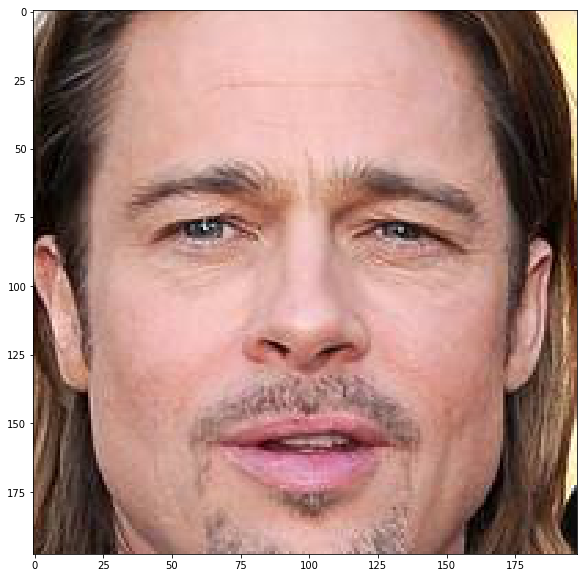

In [34]:
test_image = load_image('picture_to_check.jpg', False)

faces_images , faces = find_all_faces(test_image)
results = []

for img in faces_images:
    img = cv2.resize(img,(64,64))
    arr = np.array([img])
    results.append(nn.predict(arr))

index_of_person = -1
for index, single_result in enumerate(results):
    if single_result[0][0] == 1:
        index_of_person = index

if index_of_person != -1:
    print('The person is on the photo!')
    display_image(faces_images[index_of_person])
else:
    print('The person is not on the photo')